In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

Correlation between smoke and AQI: 0.4775799486916772
P-value of the correlation test: 0.0003942970236827778


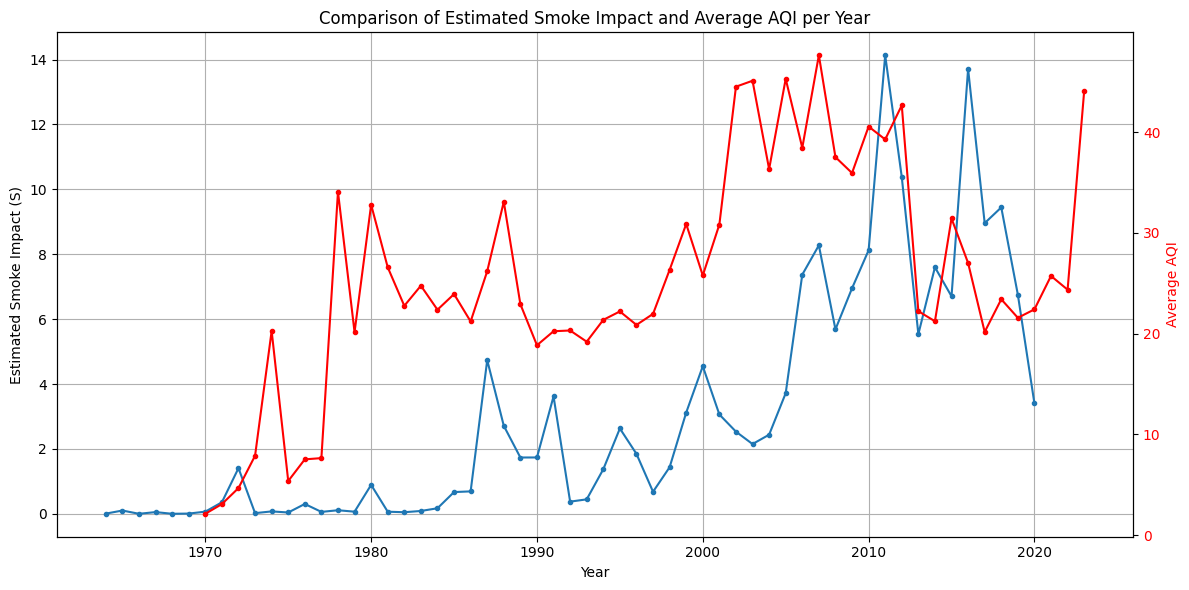

In [16]:
wildfire_df = pd.read_csv('intermediary_files/madison_wildfire_1964_2024.csv')
aqi_df = pd.read_csv("intermediary_files/yearly_aqi_1964_2024.csv")
smoke_df = pd.read_csv('intermediary_files/madison_annual_smoke_estimate_1964_2024.csv')

def calculate_smoke_estimate(row):
    gis_acres = row['GIS_Acres']
    assigned_fire_type = row['Assigned_Fire_Type']
    shape_area = row['Shape_Area']
    shape_length = row['Shape_Length']
    shortest_dist = row['shortest_dist']
    circleness = row['Circleness_Scale']

    # Fire Intensity Factor
    if assigned_fire_type == "Wildfire":
        fire_intensity_factor = 5
    elif assigned_fire_type == "Likely Wildfire":
        fire_intensity_factor = 4
    elif assigned_fire_type == "Prescribed Fire":
        fire_intensity_factor = 5
    elif assigned_fire_type == "Unknown - Wildfire":
        fire_intensity_factor = 3
    else:
        fire_intensity_factor = 0.5

    # Duration Factor
    if shape_area > 1000000:
        duration_factor = 2
    elif shape_area > 500000:
        duration_factor = 1.5
    elif shape_area > 100000:
        duration_factor = 1
    else:
        duration_factor = 0.5

    # Wind Factor
    wind_factor = 2 if shape_length / shape_area > 0.01 else 0.5

    # Calculate Smoke Estimate
    smoke_estimate = (gis_acres * fire_intensity_factor * duration_factor * wind_factor * circleness ) / (shortest_dist)

    return smoke_estimate

wildfire_df['Smoke_Estimate'] = wildfire_df.apply(calculate_smoke_estimate, axis=1)

# Extract the year from Fire_Year and group by year to sum the smoke impact
smoke_df = wildfire_df.groupby('Fire_Year')['Smoke_Estimate'].sum().reset_index()

# Calculate annual average by dividing the annual sum by 184 (number of days betweem May to Oct)
smoke_df['Smoke_Estimate'] = smoke_df['Smoke_Estimate']/184

# Merge smoke_df and aqi_df on the year column
merged_df = pd.merge(smoke_df, aqi_df, left_on='Fire_Year', right_on='year', how='inner')

correlation, p_value = pearsonr(merged_df['Smoke_Estimate'], merged_df['aqi'])

print("Correlation between smoke and AQI:", correlation)
print("P-value of the correlation test:", p_value)

# Plot both average AQI and estimated smoke impact
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot estimated smoke impact on the primary y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Estimated Smoke Impact (S)')
ax1.plot(smoke_df['Fire_Year'], smoke_df['Smoke_Estimate'], label='Estimated Smoke Impact', marker='.')
ax1.tick_params(axis='y')

# Create a second y-axis for average AQI
ax2 = ax1.twinx()  # Create a second y-axis sharing the same x-axis

# Plot average AQI on the secondary y-axis
ax2.set_ylabel('Average AQI', color='red')
ax2.plot(aqi_df['year'], aqi_df['aqi'], color='red', label='Average AQI', marker='.')
ax2.tick_params(axis='y', labelcolor='red')

# Title and grid
plt.title('Comparison of Estimated Smoke Impact and Average AQI per Year')
ax1.grid()

# Show the plot
plt.tight_layout()
plt.show()

